**Future Note**

- Consider using ONNX for optimization when it comes to model inference

## **Medical Computer Vision Model (EfficientNet) Fine Tuning & Training Pipeline**

EfficientNet, introduced by Google in 2019, is a convolutional neural network architecture and scaling method. It achieves state-of-the-art accuracy while being up to 10 times more efficient in terms of size and speed. The graph below illustrate how EfficientNet outperforms other architectures in terms of accuracy (on ImageNet) and computing resources.

![image.png](attachment:image.png)

EfficientNet consists of different versions from b0 to b7 which differs based on the number of model parameters. Higher numbers leads to greater accuracy but at the expense of high computational resources and longer training time.

Hence, for this study, we will be using PyTorch implementation of EfficentNet, allowing the set up of EfficientNet-B5 architecture with Pre-Trained Weights. This version balances the accuracy and computational resource expense.

- Import necessary libraries

In [ ]:
import os
from glob import glob
import cv2
import time
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from google.colab import drive

import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.models as models
import torchvision.transforms as transforms
import timm

# sklearn libraries
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

**Mount Google Drive (Allow Content Access)**

In [ ]:
drive.mount('/content/drive') #Mount content in my google drive

Mounted at /content/drive


**Configurable parameters**

In [ ]:
#Data Directory
DATA_DIR = '/content/drive/MyDrive/ImageProcessing&CV_Assignment'

#Data Loaders
MIXED_PRECISION = True  # Use mixed precision training
BATCH_SIZE = 128 # Using A100 GPU (Google Colab)
PIN_MEMORY = True
NUM_WORKERS = 8  # Adjust based on CPU cores

#Model Training
NUM_EPOCHS = 25
LEARNING_RATE = 0.004 #Following rule of thumb: linear scaling rule (if batch size doubled, learning rate is also doubled)
TRAIN_SPLIT = 0.8

**Device Configuration**

In [ ]:
!nvidia-smi

Sat Apr 26 14:06:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)  # Check PyTorch version
print(torch.cuda.device_count())  # Should return 1 (or more)
print(torch.cuda.get_device_name(0))  # Should show gpu name
print(f"using device: {device}")

2.6.0+cu124
1
NVIDIA A100-SXM4-40GB
using device: cuda


**1) Load and Explore Dataset**

**Data Exploration and Visualization (EDA)**

- Import dataset

In [ ]:
#Load custom dataste with standard transformsd
skin_df = pd.read_csv(DATA_DIR+'/HAM10000_metadata.csv')

print(skin_df.head())

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


- Dataset Info

In [ ]:
print(skin_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB
None


- Dataset row length

In [ ]:
print(f"Dataset size: {len(skin_df)} images")

Dataset size: 10015 images


- Class Distribution

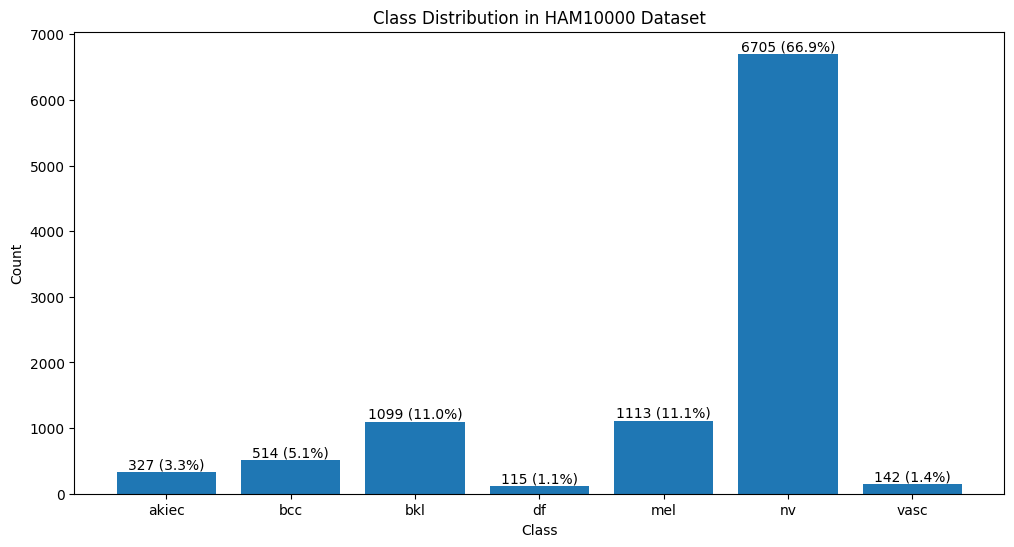

In [ ]:
# Display class distribution with a bar chart
class_counts = skin_df['dx'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
bars = plt.bar(class_counts.index, class_counts.values)
plt.title("Class Distribution in HAM10000 Dataset")
plt.xlabel("Class")
plt.ylabel("Count")

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{height} ({height/len(skin_df)*100:.1f}%)',
             ha='center', va='bottom', rotation=0)

plt.show()

The class distribution in a dataset like HAM10000 generally reflects the real-world prevalence of these conditions. Melanocytic nevi (moles) are typically much more common than some of the malignant or rarer lesion types (for example, melanoma or basal cell carcinoma). This imbalance is a known characteristic of many skin lesion datasets and is why later techniques like weighted sampling are used during training.

- Lesion Image Patient Demographic

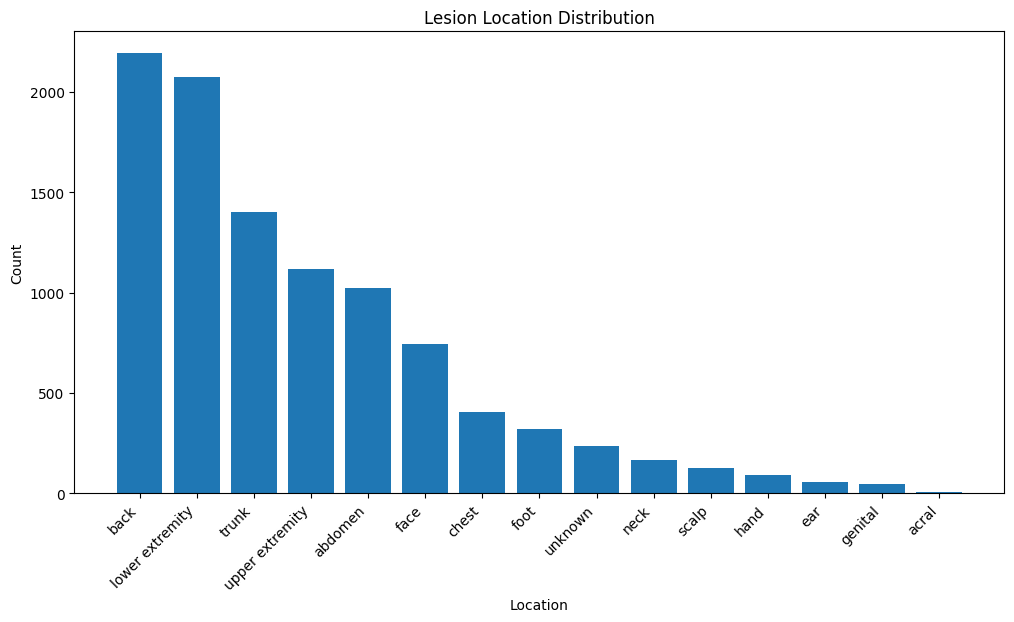

dx               akiec  bcc  bkl  df  mel    nv  vasc
localization                                         
abdomen              5   18   42   4   66   860    27
acral                0    0    0   0    0     7     0
back                29  186  202   2  324  1427    22
chest               12   47   74   0   68   200     6
ear                  3    0    6   0   17    30     0
face               113  101  319   0  104   100     8
foot                 0    4    1   2   28   284     0
genital              0    0    2   1    0    45     0
hand                13    2   14   0    1    55     5
lower extremity     65   58  174  82  192  1479    27
neck                10   14   31   0   29    81     3
scalp               14   19   34   0   14    45     2
trunk                1   11   73   0   47  1241    31
unknown              0    5   23   0   10   196     0
upper extremity     62   49  104  24  213   655    11


In [ ]:
# Lesion location distribution
location_counts = skin_df['localization'].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(location_counts.index, location_counts.values)
plt.title('Lesion Location Distribution')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

# Correlation with diagnosis (example using a cross-tabulation)
location_diagnosis_crosstab = pd.crosstab(skin_df['localization'], skin_df['dx'])
print(location_diagnosis_crosstab)

- Age and Gender

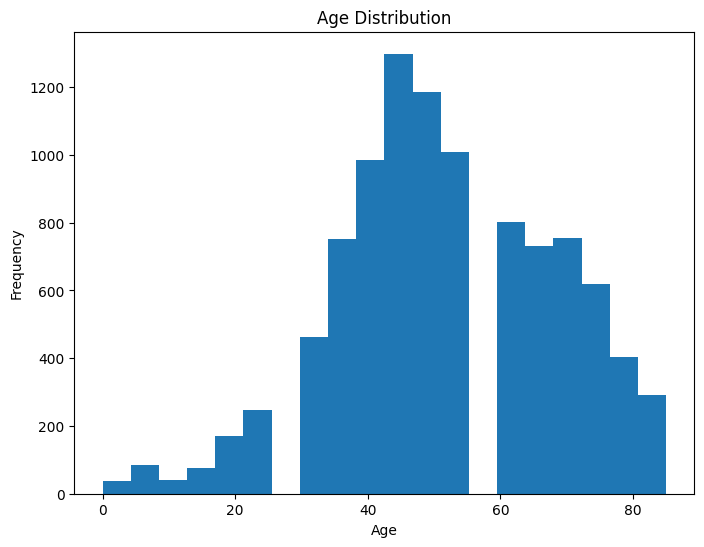

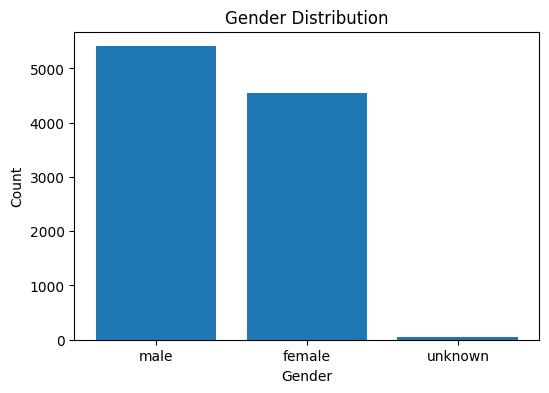

sex      dx   
female   akiec    66.698113
         bcc      65.228426
         bkl      62.494600
         df       49.326923
         mel      56.391509
         nv       44.104547
         vasc     49.589041
male     akiec    66.447964
         bcc      67.823344
         bkl      65.607029
         df       56.111111
         mel      63.326055
         nv       48.748903
         vasc     53.260870
unknown  bkl            NaN
         nv       37.500000
Name: age, dtype: float64


In [ ]:
# Age distribution
plt.figure(figsize=(8, 6))
plt.hist(skin_df['age'], bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Gender distribution
gender_counts = skin_df['sex'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(gender_counts.index, gender_counts.values)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Diagnosis by age/gender (example using groupby and aggregation)
diagnosis_by_age_gender = skin_df.groupby(['sex', 'dx'])['age'].mean()
print(diagnosis_by_age_gender)

**Data Pre-processing**

- Insert 3 columns for further assistance of Image and dataset loading

In [ ]:
image_paths = glob(os.path.join(DATA_DIR, '*', '*.jpg')) # Get all image paths in the dataset directory
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in image_paths} # Create a dictionary mapping image IDs to their paths (image_paths from cell 6)
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

i) Column 1, '**path**': Path of the image matching with the image ID within CSV

In [ ]:
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)

ii) Column 2, '**cell_type**': Full name of '**dx**' label in CSV for clarification

In [ ]:
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)

iii) Column 3, 'cell_type_idx': Corresponding index of cell type which will be used as the y category of image

In [ ]:
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [ ]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/ImageProcessing&CV_Assi...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/ImageProcessing&CV_Assi...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/ImageProcessing&CV_Assi...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/ImageProcessing&CV_Assi...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/ImageProcessing&CV_Assi...,Benign keratosis-like lesions,2


- Duplication and Missing Values handling

In [ ]:
#Duplication check
skin_df.duplicated(subset=['image_id']).sum()

np.int64(0)

In [ ]:
#Missing values check
skin_df.isnull().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0
path,0
cell_type,0
cell_type_idx,0


Filling missing age values with mean

In [ ]:
skin_df['age'] = skin_df['age'].fillna((skin_df['age'].mean())) # Fill missing age values with the mean age
skin_df.isnull().sum()

#Dont really matter in model training but just for the sake of cleaning the dataset possibly for future implementations

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,0
sex,0
localization,0
path,0
cell_type,0
cell_type_idx,0


**2) Split Dataset into Training and Validation Set**

In [ ]:
all_labels = skin_df['cell_type_idx'].values

# Perform stratified split
print("\nPerforming stratified train-validation split...")
train_indices, val_indices = train_test_split(
    np.arange(len(skin_df)),
    test_size=1-TRAIN_SPLIT,
    random_state=42,
    stratify=all_labels
)

print(f"Training samples: {len(train_indices)}")
print(f"Validation samples: {len(val_indices)}")


Performing stratified train-validation split...
Training samples: 8012
Validation samples: 2003


**3) Create and Initialize Model**

In [ ]:
print("\nCreating model...")
model_name = 'efficientnet_b0'
num_classes = 7
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)

input_size = 224

# Move model to device
model = model.to(device)
print(f"Created {model_name} with {num_classes} output classes")


Creating model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Created efficientnet_b0 with 7 output classes


**4) Data (Image) Transformation Definition**

In [ ]:
# Get all image paths from the HAM10000 images folder
IMG_DIR = DATA_DIR+'/HAM10000_images'
image_paths = glob(os.path.join(IMG_DIR, '*.jpg'))
print(f"Found {len(image_paths)} images for computing normalization.")

Found 10025 images for computing normalization.


- Compute normalization values from the dataset images

In [ ]:
def compute_img_mean_std(image_paths):
    """
    Compute the channel-wise mean and std for a list of image paths.
    Images are resized to 224x224 and converted from BGR to RGB when reversing order.
    """
    img_h, img_w = 224, 224
    imgs = []

    for path in tqdm(image_paths, desc="Computing mean & std"):
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    # Stack images along a new axis (result: H x W x Channels x N)
    imgs = np.stack(imgs, axis=3)
    imgs = imgs.astype(np.float32) / 255.0  # scale pixels to [0,1]

    means, stdevs = [], []
    # Compute mean and std for each channel
    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    # Reverse the order to go from BGR (OpenCV) to RGB
    means.reverse()
    stdevs.reverse()

    print("Computed normMean =", means)
    print("Computed normStd  =", stdevs)
    return means, stdevs

In [ ]:
# Compute normalization values (Mean and standard deviation of RGB channels); these will be used in transform.Normalize()
# computed_means, computed_stds = compute_img_mean_std(image_paths)

# Computed mean and standard deviation values is manually initialized here from vs code due to google colab unable to process because of RAM limitations

computed_means = [0.7630331, 0.5456457, 0.5700467]
computed_stds = [0.1409281, 0.15261227, 0.16997086]

print(f"computed_means:{computed_means}, computer standard deviation:{computed_stds}")

computed_means:[0.7630331, 0.5456457, 0.5700467], computer standard deviation:[0.1409281, 0.15261227, 0.16997086]


**Image Transformation**
- Transform input image function for loading testing or future input images in consistent form (resized, cropped, normalized) onto the EfficientNet Model for a more accurate output classification.

- Augmentation transform of training image function with random image processing (Horizontal flip, vertical flip, rotation, color jitter, gaussian blur) to introduce variability and improve generalization (prevent overfitting) of images from dataset along with image normalization.

In [ ]:
def get_standard_transform(input_size, computed_means, computed_stds):
    # Standard transformation for testing, validation, test and input
    return transforms.Compose([
        transforms.Resize((input_size,input_size)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=computed_means, std=computed_stds)
    ])

#Augmentation transformation are applied only to the training dataset after splitting
def get_augmentation_transform(input_size, computed_means, computed_stds):
        return transforms.Compose([
            transforms.Resize((input_size,input_size)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=computed_means, std=computed_stds),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=45),
            transforms.RandomApply([
                transforms.RandomChoice([
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    transforms.GaussianBlur(3)
                ]),
            ], p=0.1)
        ])

**5) HAM10000 Custom Dataset**

- **Custom dataset** for loading images and labels while applying transformations and augmentations

In [ ]:
class HAM10000Dataset(Dataset):
    def __init__(self, df, transform=None):
        """Optimized dataset class for HAM10000"""
        self.metadata = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # Load data and get label
        X = Image.open(self.metadata['path'][idx]) #Load image
        y = torch.tensor(int(self.metadata['cell_type_idx'][idx])) #Load label

        if self.transform:
            X = self.transform(X) #Apply transformation to the loaded image if transform is provided

        return X, y #Return the transformed image and label

**6) Create Training and Validation Datasets**

In [ ]:
# Training dataset with augmentation
train_dataset = HAM10000Dataset(
    df = skin_df.iloc[train_indices],
    transform=get_augmentation_transform(input_size, computed_means, computed_stds)
)

print(f"Training dataset size: {len(train_dataset)}")

# Validation dataset
val_dataset = HAM10000Dataset(
    df = skin_df.iloc[val_indices],
    transform=get_standard_transform(input_size, computed_means, computed_stds)
)

print(f"Validation dataset size: {len(val_dataset)}")

Training dataset size: 8012
Validation dataset size: 2003


****Additional: Handle Class Imbalance with Weighted Sampling**

Weighted sampling, also known as class weighting, is a good technique for addressing class imbalance in machine learning, as it helps the model pay more attention to the minority class by assigning higher weights to its samples during training.

In [ ]:
# Calculate class distribution in training set
train_labels = skin_df['cell_type_idx'].iloc[train_indices].values # Extract labels using train_indices
class_counts = np.bincount(train_labels)
#Add a check to further ensure all classes are represented
if len(class_counts) < num_classes:
    class_counts = np.pad(class_counts, (0, num_classes - len(class_counts)), 'constant')

# Create weighted sampler
weights = 1. / class_counts
samples_weights = weights[train_labels]
samples_weights = torch.from_numpy(samples_weights).float()

sampler = torch.utils.data.WeightedRandomSampler(
    weights=samples_weights,
    num_samples=len(train_indices),
    replacement=True
)

**7) Create Data Loaders**

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,  # Use the weighted sampler
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY, #or faster GPU transfer
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE * 2,  # Larger validation batches
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

**8) Define Loss Function, Optimizer, Scheduler and Scaler**

In [ ]:
# Optimizer and loss function
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Learning rate scheduler implemented due to large batch size and learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #ReduceLROnPlateau helps to prevent overfitting
    optimizer, mode='min', factor=0.1, patience=3, verbose=True
)

#Gradient scaler with Mixed precision for faster training
scaler = torch.cuda.amp.GradScaler(enabled=MIXED_PRECISION)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-30-22f7be75def7>:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=MIXED_PRECISION)


**9) Model Training**

Average Meter function used for training process to calculate loss and accuracy

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

- Training and validation loop for Phase 1 (Backbone Freeze) & Phase 2 (Backbone Unfreeze)

In [ ]:
# Initialize history dictionary to track metrics across both phases
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'phase': []  # Track which phase each epoch belongs to
}

In [ ]:
#Function that runs one training epoch with evaluation
def train_epoch(model, train_loader, val_loader, criterion, optimizer, scaler, scheduler, epoch, phase):
    print(f"\n{'='*20} EPOCH {epoch} [ {phase} ] {'='*20}")

    #TRAINING PHASE
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad() # To Zero the gradients

        #EfficientNet loves mixed precision training (float16). Without this method, memory and compute costs are higher
        with torch.cuda.amp.autocast(enabled=MIXED_PRECISION): # Change device_type='cuda' to enabled=MIXED_PRECISION
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc = correct / labels.size(0)

        train_loss.update(loss.item(), labels.size(0))
        train_acc.update(acc, labels.size(0))

    #VALIDATION PHASE
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()

    #Obtain latest models predictions on validation loader/dataset and corresponding true labels for those data points
    all_predictions = []
    all_targets = []

    with torch.no_grad(): #Disable gradient calculations
        for i, (images, labels) in enumerate(val_loader): #Use validation loader or test loader
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)
            loss = criterion(outputs, labels)

            #Get predicted class indices
            _, predicted = torch.max(outputs.data, 1)
            #For Val_acc, check whether the predicted equates to the actual label
            correct = (predicted == labels).sum().item()
            acc = correct / labels.size(0)

            #For confusion matrix, which obtains total number value for every 7 prediction and label
            all_predictions.extend(predicted.cpu().numpy()) #Move predictions to CPU
            all_targets.extend(labels.cpu().numpy()) #Move labels to CPU

            val_loss.update(loss.item(), labels.size(0))
            val_acc.update(acc, labels.size(0))

    #Update learning rate scheduler based on the validation loss
    scheduler.step(val_loss.avg)

    # Append the metrics for this epoch to the global history dictionary
    history['train_loss'].append(train_loss.avg)
    history['train_acc'].append(train_acc.avg)
    history['val_loss'].append(val_loss.avg)
    history['val_acc'].append(val_acc.avg)
    history['phase'].append(phase)

    print(f"Epoch {epoch} [{phase}] Summary:")
    print(f"  Train Loss: {train_loss.avg:.4f}, Train Acc: {train_acc.avg:.4f}")
    print(f"  Val Loss:   {val_loss.avg:.4f}, Val Acc:   {val_acc.avg:.4f}")

    return train_loss.avg, train_acc.avg, val_loss.avg, val_acc.avg, all_predictions, all_targets


The benefits of this approach by freezing and unfreezing backbone layers include

Much Faster Initial Training:
- Phase 1 should complete in minutes instead of hours
- Get a reasonable model very quickly

Better Optimization:
- The classifier adapts first to the new task
- Then the backbone adapts while keeping its pretrained knowledge

Early Results:
- Can evaluate model performance after phase 1
- Decide if phase 2 is necessary based on phase 1 results

Resource Efficiency:
- Can test multiple hyperparameter configurations quickly in phase 1
- Only invest time in phase 2 for promising configurations


- Phase 1: Classifier only (frozen backbone)

Basically only the parameters of last layer are updated, while others remain fixed

In [ ]:
print("\n" + "="*50)
print("PHASE 1: Training classifier only (backbone frozen)")
print("="*50)

# feature_extract is a boolean that defines if we are finetuning or feature extracting.
# If feature_extract = False, the model is finetuned and all model parameters are updated.
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.

# Freeze backbone
for name, param in model.named_parameters():
    if 'classifier' not in name:  # For EfficientNet
        param.requires_grad = False

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%} of total)")

# Higher learning rate for classifier-only training
optimizer_phase1 = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

# Phase 1 training
phase = "phase 1"
phase1_epochs = 20
best_val_acc_p1 = 0

for epoch in range(1, phase1_epochs + 1):
    # Call the same training function
    train_loss, train_acc, val_loss, val_acc, _ , _  = train_epoch(
        model, train_loader, val_loader, criterion, optimizer_phase1, scaler, scheduler, epoch, phase="phase 1")

    # Save the best model from phase 1
    if val_acc > best_val_acc_p1:
        best_val_acc_p1 = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer_phase1.state_dict(),
            'val_acc': val_acc,
        }, DATA_DIR + "/trained_model/phase1_best.pth")
        print(f"New best model saved! Val Acc: {val_acc:.4f}")


PHASE 1: Training classifier only (backbone frozen)
Trainable parameters: 8,967 (0.22% of total)

==================== EPOCH 1 [ phase 1 ] ====================


<ipython-input-33-dfd6180338e3>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=MIXED_PRECISION): # Change device_type='cuda' to enabled=MIXED_PRECISION


Epoch 1 [phase 1] Summary:
  Train Loss: 3.0594, Train Acc: 0.2233
  Val Loss:   2.7012, Val Acc:   0.2931
New best model saved! Val Acc: 0.2931

==================== EPOCH 2 [ phase 1 ] ====================
Epoch 2 [phase 1] Summary:
  Train Loss: 2.2244, Train Acc: 0.3643
  Val Loss:   2.2667, Val Acc:   0.3894
New best model saved! Val Acc: 0.3894

==================== EPOCH 3 [ phase 1 ] ====================
Epoch 3 [phase 1] Summary:
  Train Loss: 1.9203, Train Acc: 0.4346
  Val Loss:   2.1437, Val Acc:   0.4169
New best model saved! Val Acc: 0.4169

==================== EPOCH 4 [ phase 1 ] ====================
Epoch 4 [phase 1] Summary:
  Train Loss: 1.7261, Train Acc: 0.4765
  Val Loss:   1.9056, Val Acc:   0.4553
New best model saved! Val Acc: 0.4553

==================== EPOCH 5 [ phase 1 ] ====================
Epoch 5 [phase 1] Summary:
  Train Loss: 1.5818, Train Acc: 0.5131
  Val Loss:   1.7444, Val Acc:   0.4883
New best model saved! Val Acc: 0.4883

==================== E

- Phase 2: Fine-tuning (full model)

In [ ]:
print("\n" + "="*50)
print("PHASE 2: Fine-tuning entire model")
print("="*50)

#Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,} (100% of total)")

# Lower learning rate for fine-tuning
optimizer_phase2 = optim.Adam(model.parameters(), lr=1e-5)

# Early stopping parameters
patience = 12 #Number of epochs to wait for improvement
best_val_loss = float('inf') #Initialize with a very large value
epochs_without_improvement = 0

# Phase 2 training
phase2_epochs = 150
training_counter = 0
best_val_acc_p2 = best_val_acc_p1 #Start from the best accuracy from phase 1

for epoch in range(1, phase2_epochs + 1):
    training_counter += 1

    # Call the same training function again
    train_loss, train_acc, val_loss, val_acc, predictions, targets = train_epoch(
        model, train_loader, val_loader, criterion, optimizer_phase2, scaler, scheduler, epoch, phase='Phase 2')

    # Save the best model from phase 2 ONLY after early stopping, based on accuracy
    if val_acc > best_val_acc_p2:  # Change condition to check for accuracy improvement
        best_val_acc_p2 = val_acc
        epochs_without_improvement = 0

        all_predictions, all_targets = predictions, targets

        #Save the model here since it's the best so far
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer_phase2.state_dict(),
            'val_acc': val_acc,
        }, DATA_DIR + "/trained_model/phase2_best.pth")
        print(f"New best model saved! Val Acc: {val_acc:.4f}")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered! No improvement in {patience} epochs.")
            break # Exit training loop


PHASE 2: Fine-tuning entire model
Trainable parameters: 4,016,515 (100% of total)

==================== EPOCH 1 [ Phase 2 ] ====================


<ipython-input-33-dfd6180338e3>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=MIXED_PRECISION): # Change device_type='cuda' to enabled=MIXED_PRECISION


Epoch 1 [Phase 2] Summary:
  Train Loss: 0.9471, Train Acc: 0.6629
  Val Loss:   1.2080, Val Acc:   0.6081
New best model saved! Val Acc: 0.6081

==================== EPOCH 2 [ Phase 2 ] ====================
Epoch 2 [Phase 2] Summary:
  Train Loss: 0.8605, Train Acc: 0.6956
  Val Loss:   1.1346, Val Acc:   0.6266
New best model saved! Val Acc: 0.6266

==================== EPOCH 3 [ Phase 2 ] ====================
Epoch 3 [Phase 2] Summary:
  Train Loss: 0.8288, Train Acc: 0.7103
  Val Loss:   1.0689, Val Acc:   0.6505
New best model saved! Val Acc: 0.6505

==================== EPOCH 4 [ Phase 2 ] ====================
Epoch 4 [Phase 2] Summary:
  Train Loss: 0.7557, Train Acc: 0.7329
  Val Loss:   1.0726, Val Acc:   0.6500

==================== EPOCH 5 [ Phase 2 ] ====================
Epoch 5 [Phase 2] Summary:
  Train Loss: 0.7374, Train Acc: 0.7403
  Val Loss:   1.0349, Val Acc:   0.6605
New best model saved! Val Acc: 0.6605

==================== EPOCH 6 [ Phase 2 ] ===================

- Overall Phase 1 and 2 Accuracy Results

In [ ]:
print("\nTraining complete!")
print(f"Phase 1 best val accuracy: {best_val_acc_p1:.4f}")
print(f"Phase 2 best val accuracy: {best_val_acc_p2:.4f}")
print(f"Improvement: {best_val_acc_p2 - best_val_acc_p1:.4f}")


Training complete!
Phase 1 best val accuracy: 0.5966
Phase 2 best val accuracy: 0.8672
Improvement: 0.2706


**13) Model Evaluation**

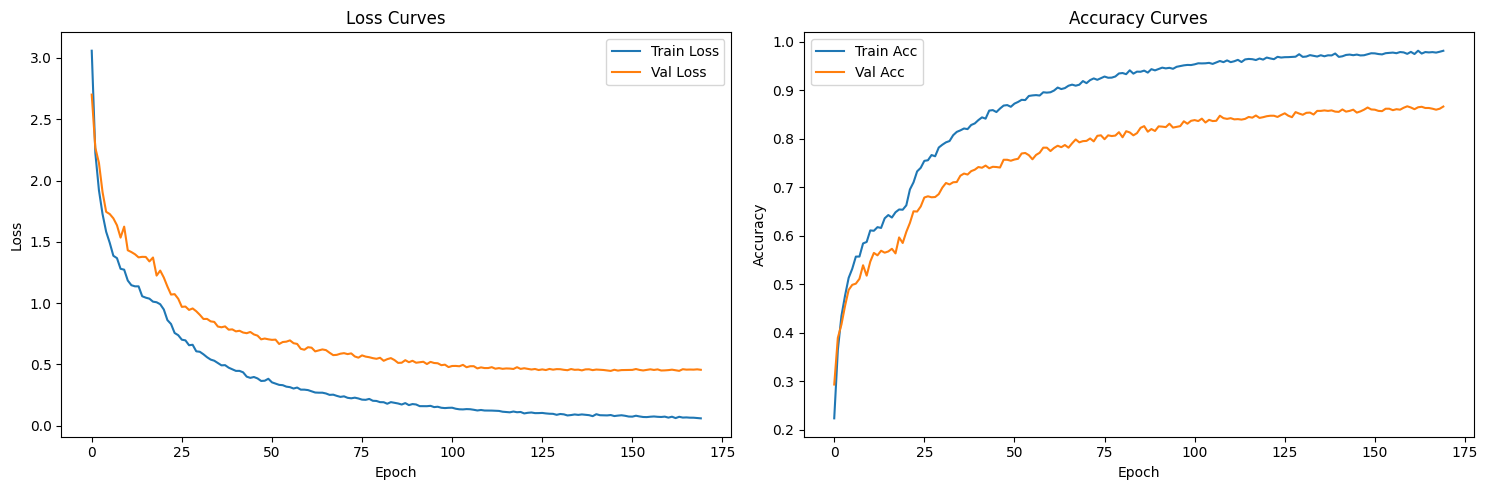

In [ ]:
plt.figure(figsize=(15, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.show()

**14) Generate Final Evaluation Metrics: Confusion Matrix**

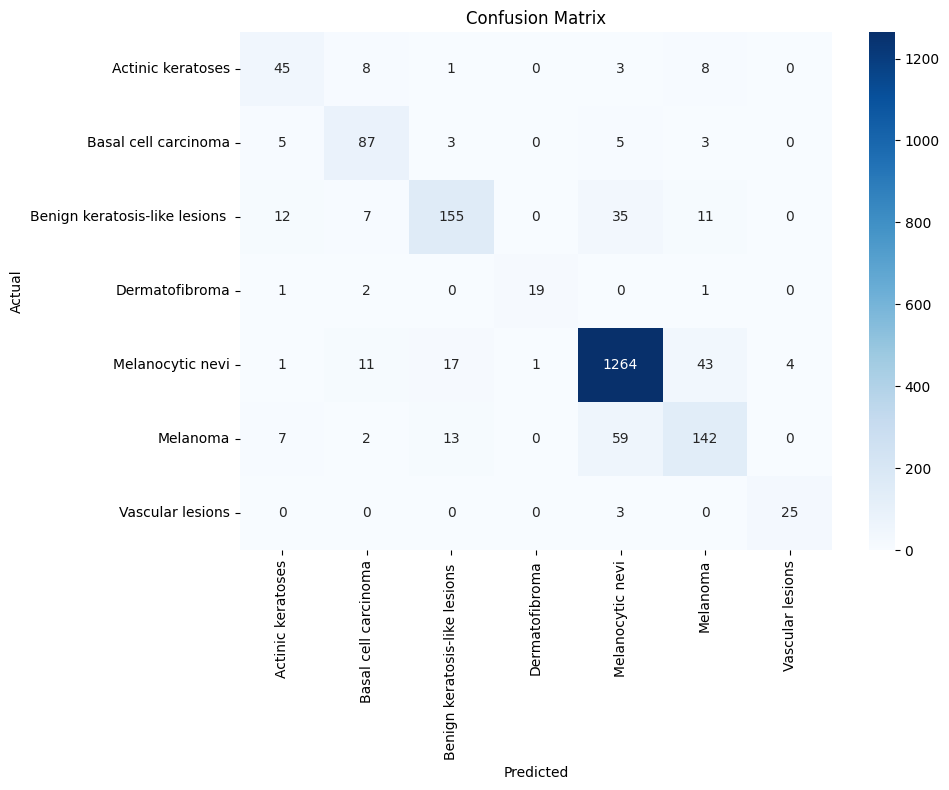


Classification Report:
                                precision    recall  f1-score   support

             Actinic keratoses       0.63      0.69      0.66        65
          Basal cell carcinoma       0.74      0.84      0.79       103
Benign keratosis-like lesions        0.82      0.70      0.76       220
                Dermatofibroma       0.95      0.83      0.88        23
              Melanocytic nevi       0.92      0.94      0.93      1341
                      Melanoma       0.68      0.64      0.66       223
              Vascular lesions       0.86      0.89      0.88        28

                      accuracy                           0.87      2003
                     macro avg       0.80      0.79      0.79      2003
                  weighted avg       0.87      0.87      0.87      2003



In [ ]:
# Create confusion matrix from sklearn
cm = confusion_matrix(all_targets, all_predictions)

# Find class name, "cell_type" that corresponds from cell_type_idx which is the label (y) in HAM10000Dataset
# Get the categories (cell_type names) in the order of cell_type_idx
class_names = list(pd.Categorical(skin_df['cell_type']).categories)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(all_targets, all_predictions, target_names=class_names))